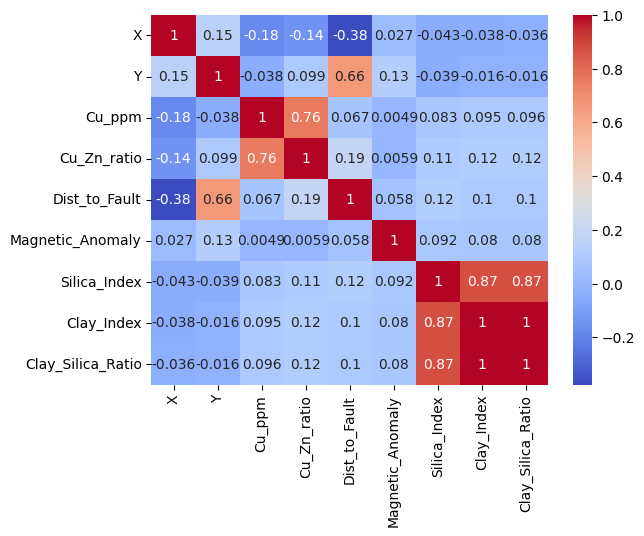

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the preprocessed data
final_features = pd.read_csv("final_features.csv")

# Drop rows with missing values (if any)
final_features = final_features.dropna()

# Display feature correlations (optional)
import seaborn as sns
import matplotlib.pyplot as plt  # Import matplotlib.pyplot as plt
sns.heatmap(final_features.corr(), annot=True, cmap="coolwarm")
plt.savefig("feature_correlations.png")

In [4]:
# Create the 'Mineralized' column based on a condition (e.g., Cu_ppm > 30 is mineralized)
final_features['Mineralized'] = (final_features['Cu_ppm'] > 30).astype(int)

# Features (X) - Drop coordinates and target
X = final_features.drop(['X', 'Y', 'Mineralized'], axis=1)  

# Target (y) - Binary labels (1: mineralized, 0: non-mineralized)
y = final_features['Mineralized']  

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1339
           1       1.00      1.00      1.00       660

    accuracy                           1.00      1999
   macro avg       1.00      1.00      1.00      1999
weighted avg       1.00      1.00      1.00      1999

ROC-AUC Score: 0.9990851381628081


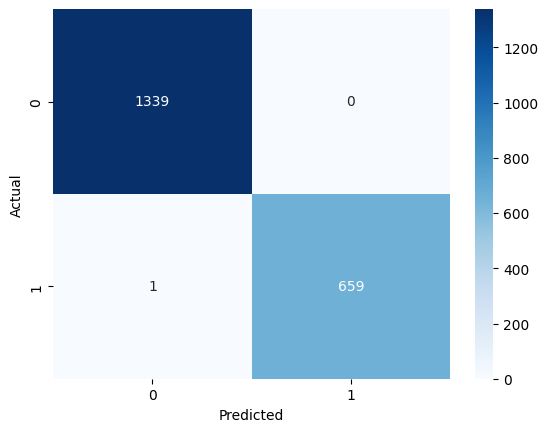

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("confusion_matrix.png")

C:\Users\jasje\AppData\Local\Temp\ipykernel_20440\704772930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis")


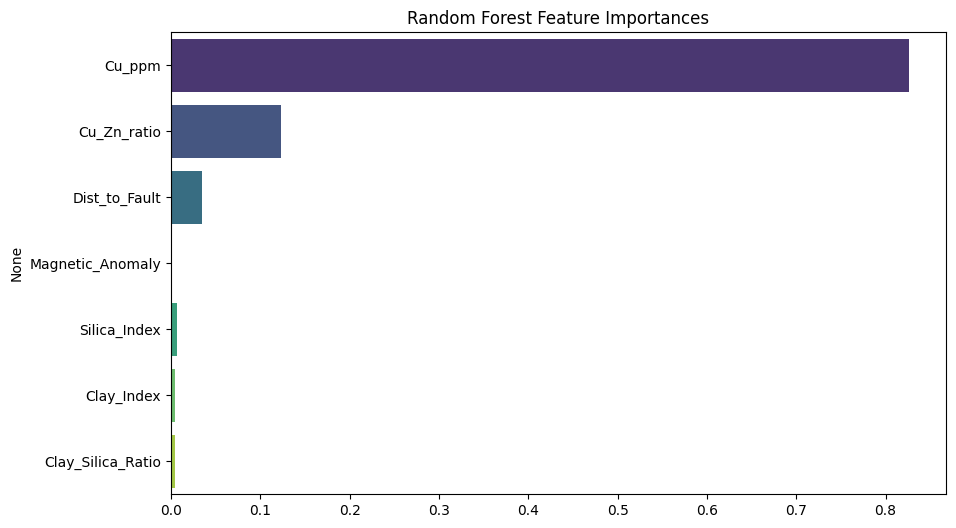

In [6]:
# Plot feature importances
importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.savefig("feature_importances.png")

In [7]:
# Predict probabilities for all locations
final_features['Mineral_Probability'] = rf_model.predict_proba(X)[:, 1]

# Save predictions with coordinates
predictions_with_coords = final_features[['X', 'Y', 'Mineral_Probability']]
predictions_with_coords.to_csv("mineral_probability_map.csv", index=False)

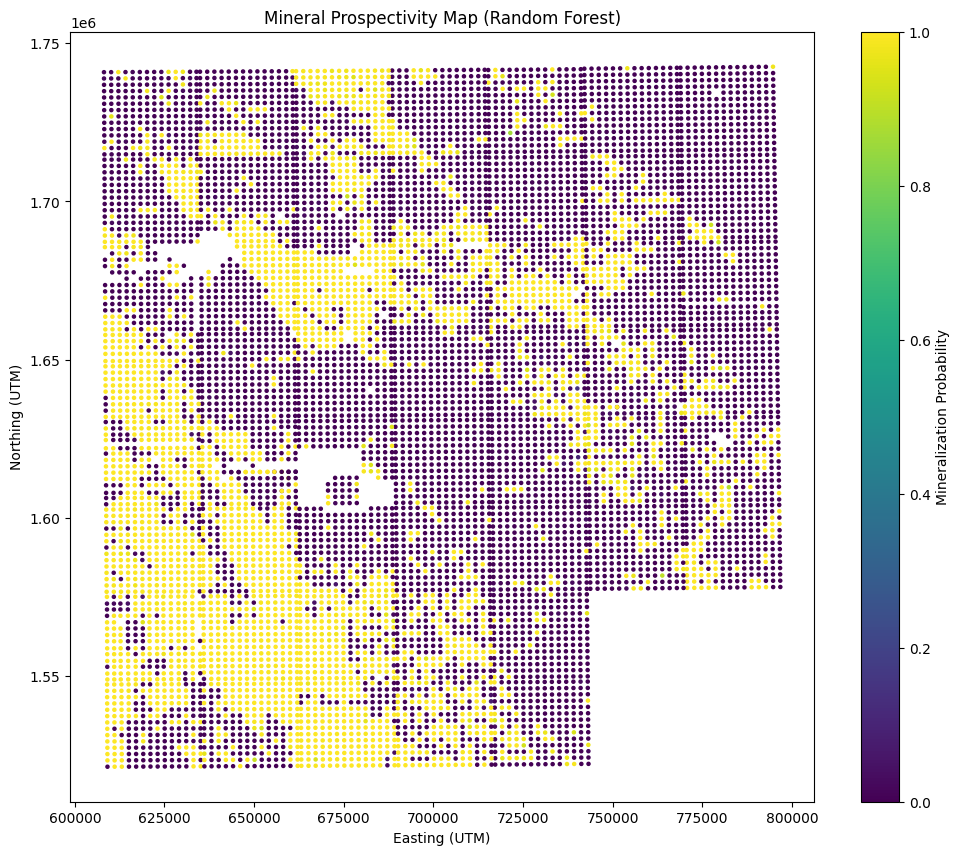

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Create a grid for plotting
x = predictions_with_coords['X'].values
y = predictions_with_coords['Y'].values
z = predictions_with_coords['Mineral_Probability'].values

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(x, y, c=z, cmap='viridis', s=5, norm=Normalize(vmin=0, vmax=1))
plt.colorbar(label='Mineralization Probability')
plt.title("Mineral Prospectivity Map (Random Forest)")
plt.xlabel("Easting (UTM)")
plt.ylabel("Northing (UTM)")
plt.savefig("prospectivity_map.png", dpi=300)

In [28]:
import shap

# Explain predictions
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, plot_type="bar")
plt.savefig("shap_feature_importance.png")

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [29]:
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 4.2 MB/s eta 0:00:36
   ---------------------------------------- 1.6/150.0 MB 4.2 MB/s eta 0:00:36
    --------------------------------------- 2.4/150.0 MB 3.9 MB/s eta 0:00:38
    --------------------------------------- 3.4/150.0 MB 4.1 MB/s eta 0:00:36
   - -------------------------------------- 3.9/150.0 MB 4.1 MB/s eta 0:00:36
   - -------------------------------------- 5.0/150.0 MB 4.1 MB/s eta 0:00:36
   - -------------------------------------- 5.8/150.0 MB 4.1 MB/s eta 0:00:36
   - -------------------------------------- 6.8/150.0 MB 4.1 MB/s eta 0:00:35
   -- ------------------------------------- 7.6/150.0 MB 4.1 MB/s eta 0:00:35
   -- ------------------------------------- 8.4/150.0 MB 4.2 MB/s eta 0:00:35
   -- ------------------------------------- 9.4/150.0 MB 4.1 MB/s eta 0:00:35
 

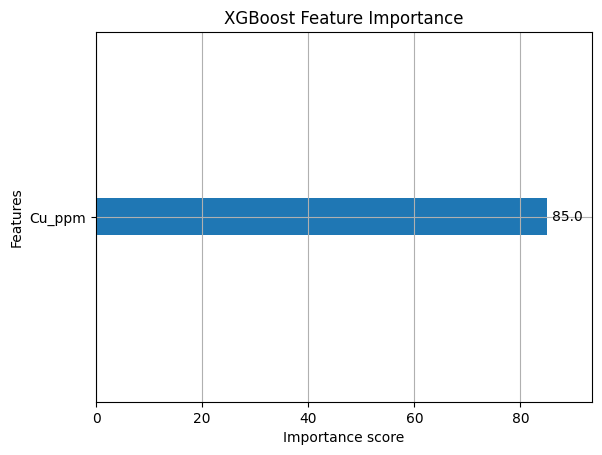

In [30]:
# Plot XGBoost feature importance
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.savefig("xgb_feature_importance.png")

In [31]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [34]:
import geopandas as gpd

# Load GSI's mineral exploration blocks
exploration_blocks = gpd.read_file("../datasets/Exploration_data/exploration_data_gis_view.shp")

# Convert predictions to GeoDataFrame
gdf_predictions = gpd.GeoDataFrame(
    final_features,
    geometry=gpd.points_from_xy(final_features.X, final_features.Y),
    crs="EPSG:32643"
)

# Spatial join: Check if high-probability points fall within known blocks
high_prob_points = gdf_predictions[gdf_predictions['Mineral_Probability'] > 0.7]
validation = gpd.sjoin(high_prob_points, exploration_blocks, how='left', predicate='within')

# Calculate accuracy
matched = validation[~validation.index_right.isna()].shape[0]
print(f"High-probability points overlapping with GSI blocks: {matched}/{len(high_prob_points)}")

High-probability points overlapping with GSI blocks: 0/3353


C:\Users\jasje\AppData\Local\Temp\ipykernel_20440\2397694769.py:15: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32643
Right CRS: EPSG:4326

  validation = gpd.sjoin(high_prob_points, exploration_blocks, how='left', predicate='within')


C:\Users\jasje\AppData\Local\Temp\ipykernel_20440\2197840902.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


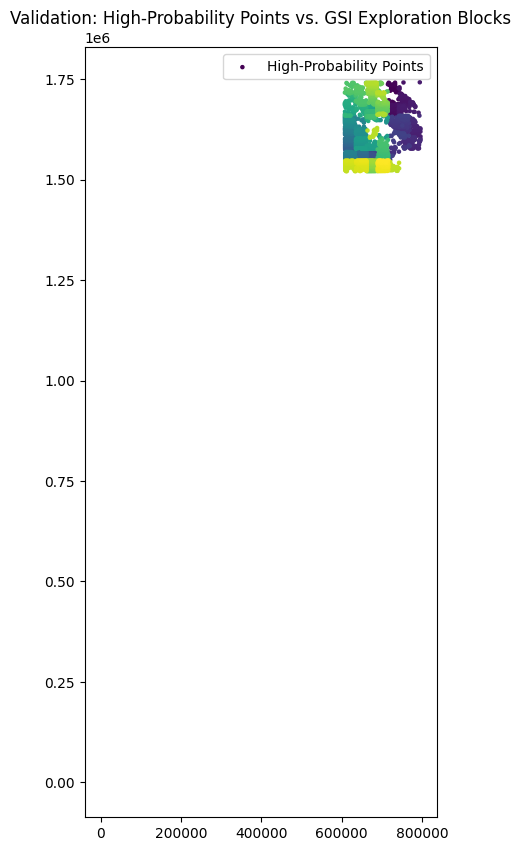

In [35]:
fig, ax = plt.subplots(figsize=(12, 10))
exploration_blocks.plot(ax=ax, color='none', edgecolor='red', label='GSI Blocks')
high_prob_points.plot(ax=ax, c='Mineral_Probability', cmap='viridis', markersize=5, label='High-Probability Points')
plt.legend()
plt.title("Validation: High-Probability Points vs. GSI Exploration Blocks")
plt.savefig("validation_map.png")

In [36]:
# Save as a shapefile for GIS software
high_prob_points.to_file("final_prospectivity_map.shp")

C:\Users\jasje\AppData\Local\Temp\ipykernel_20440\3258416532.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  high_prob_points.to_file("final_prospectivity_map.shp")
C:\Users\jasje\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Cu_Zn_ratio' to 'Cu_Zn_rati'
  ogr_write(
C:\Users\jasje\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Dist_to_Fault' to 'Dist_to_Fa'
  ogr_write(
C:\Users\jasje\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Magnetic_Anomaly' to 'Magnetic_A'
  ogr_write(
C:\Users\jasje\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Silica_Index' to 'Silica_Ind'
  ogr_write(
C:\Users\jasje\AppData\Roaming\Python\Python312\site-packages\pyogrio\r